In [4]:
import os

os.environ["LANGCHAIN_TRACING"]="true"
os.environ["LANGCHAIN_ENDPOINT"]= "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]= "***"
os.environ["MISTRAL_API_KEY"] = "***"

from langchain_mistralai import ChatMistralAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableLambda


In [11]:
from fastapi import FastAPI
import uvicorn
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_mistralai import ChatMistralAI
from langserve import add_routes
import nest_asyncio
from langchain_core.runnables import chain
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

nest_asyncio.apply()

In [ ]:
!ngrok config add-authtoken ***

----------------------------------------------------------
## Creating complex applications with LangGraph
Now we will build on this application to make it more complex: we’ll add a number of features to demonstrate the document embedding and agentic features of LangChain through the LangGraph library.

We’re going to build on this framework in a few key ways by designing a question-answering application that chains together
several important capabilities:
- We will enable open-ended dialogue through a chatbot
- We’ll use a vector database to retrieve relevant documents to our query from an internal store
- We’ll add a memory that allows the bot to keep track of its interactions with us
- We’ll provide the ability for feedback from a human-in-the-loop user
- We’ll provide the ability to look on the internet for additional content in response to prompts

### Adding a chat interface
The first step in our interface will be an open-ended dialogue with a chatbot

<span style="color: magenta;">State</span> – a container with the accumulated messages that are shared across the components of our LLM application, allowing us to append messages as we receive them and act on the latest prompt from the user.

In [2]:

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

Initialize the graph that will hold our application by calling <span style="color: magenta;">StateGraph</span>.

The <span style="color: chartreuse;">chatbot</span> will be the first element or node of this graph, and we’ll add edges, which route the output of this chatbot to different downstream tasks.

In [7]:
model = ChatMistralAI(model="mistral-large-latest")

# wrapping the model in a chatbot function, which invokes the model on the messages in the graph state.
def chatbot(state: State):
    return {"messages": model.invoke(state["messages"])}
#  input function, which passes user prompts to the chatbot
def input(question):
    return {"messages": question}
# output function that extracts the response.
def output(state: State):
    return state["messages"][-1].content

In [8]:
# declare the graph and add the chatbot.
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()
#define a chain where the graph is the middle element
assistant = RunnableLambda(input) | graph | RunnableLambda(output)

In [9]:
#run a FastAPI app as before to expose a REST API for the assistant
'''app = FastAPI(
    title="LangChain Server",
    version="1.0",
    description="A simple API server using LangChain's Runnable interfaces",
)
add_routes(
    app,
    assistant.with_types(input_type=str, output_type=str),
    path="/assistant",
)
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="debug")'''
from pyngrok import ngrok
import threading
import uvicorn
import nest_asyncio

nest_asyncio.apply()

# Start ngrok tunnel first
ngrok_tunnel = ngrok.connect(8000)
print("Public URL:", ngrok_tunnel.public_url + "/chain/playground")


Public URL: https://fabafca8ba4a.ngrok-free.app/chain/playground


In [12]:

# Assuming you already have an 'assistant' object defined
app = FastAPI(
    title="LangChain Server",
    version="1.0",
    description="A simple API server using LangChain's Runnable interfaces",
)

add_routes(
    app,
    assistant.with_types(input_type=str, output_type=str),
    path="/assistant",
)

def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="debug")

# Start the server in a background thread
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()

print("FastAPI server is running at http://0.0.0.0:8000")

FastAPI server is running at http://0.0.0.0:8000


INFO:     Started server process [16956]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)



     __          ___      .__   __.   _______      _______. _______ .______     ____    ____  _______
    |  |        /   \     |  \ |  |  /  _____|    /       ||   ____||   _  \    \   \  /   / |   ____|
    |  |       /  ^  \    |   \|  | |  |  __     |   (----`|  |__   |  |_)  |    \   \/   /  |  |__
    |  |      /  /_\  \   |  . `  | |  | |_ |     \   \    |   __|  |      /      \      /   |   __|
    |  `----./  _____  \  |  |\   | |  |__| | .----)   |   |  |____ |  |\  \----.  \    /    |  |____
    |_______/__/     \__\ |__| \__|  \______| |_______/    |_______|| _| `._____|   \__/     |_______|
    
LANGSERVE: Playground for chain "/assistant/" is live at:
LANGSERVE:  │
LANGSERVE:  └──> /assistant/playground/
LANGSERVE:
LANGSERVE: See all available routes at /docs/


In [13]:
import requests
result = requests.post(
"https://6f275c9536a5.ngrok-free.app/assistant/invoke",
json={"input": "what is langgraph?"}
)
result.content


b'<!DOCTYPE html>\n<html class="h-full" lang="en-US" dir="ltr">\n  <head>\n    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Regular-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />\n    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-RegularItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />\n    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Medium-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />\n    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-Semibold-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />\n    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/euclid-square/EuclidSquare-MediumItalic-WebS.woff" as="font" type="font/woff" crossorigin="anonymous" />\n    <link rel="preload" href="https://cdn.ngrok.com/static/fonts/ibm-plex-mono/IBMPl

### Adding a vector store for RAG

Improving the chatbot’s ability to answer questions about LangChain by retrieving relevant
code snippets. To do so, we will:
1. Download the contents of the langchain library from GitHub.
2. Store it in a <span style="color: magenta;">vector database</span>.
3. Add a <span style="color: magenta;">retrieval step</span> in our graph.

Storing the actual code of the LangChain project in an accessible database in the application, willprovide the ability to retrieve relevant snippets of code that will provide additional background information for the model when responding to questions, provideing a more specific and relevant responses.

  Then,
we’ll split the files into overlapping chunks, which we’ll embed using the FastEmbedEmbeddings
model, which converts text into numerical vectors that we can search. Finally, we’ll add these
overlapping vector embeddings of the langchain source code to a local, in-memory vector
database we create with InMemoryVectorStore

In [17]:
from git import Repo
from langchain_community.document_loaders import GitLoader
from langchain_core.documents import Document
from langchain_mistralai import MistralAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [19]:
# Grab the data with GitLoader.
try:
    repo = Repo.clone_from(
    "https://github.com/langchain-ai/langchain",
    to_path="./langchain"
    )
except:
    pass    

In [20]:
branch = repo.head.reference
# filter out only files with Python code.
loader = GitLoader(
    repo_path="./langchain/",
    file_filter=lambda file_path: file_path.endswith(".py"),
    branch=branch
)

code = loader.load()


In [21]:

# Split the files into overlapping chunks.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)
all_splits = text_splitter.split_documents(code)


In [22]:
# embed using the FastEmbedEmbeddings model.
'''embeddings = MistralAIEmbeddings( 
    model="mistral-large-latest",
    timeout=500.0
)'''
embeddings = MistralAIEmbeddings(
    model="mistral-embed",   # or mistral-embed-small
    timeout=500.0
)

In [23]:
#add the overlapping vector embeddings of the langchain source code to a local, in-memory vector database 
vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(all_splits)

['654a4e89-53f0-48ad-b19e-e2507aa992aa',
 'a89d4562-4362-4f8c-92c9-0d86f27d43b2',
 '0246d3d5-57cb-4b75-9fd9-7732a422b725',
 '32968697-984c-463d-a162-0803c042a5c7',
 '5f6270ea-c7f4-44a2-bea1-9de5374b19c3',
 '1ddfb146-101e-4f42-85c3-82469518ace9',
 '03139b3b-bc75-4bdb-9e41-e837c1b63f83',
 '8d84bf16-c74e-4c92-bdf3-dfd9d3fd5b46',
 '06ba822d-c010-4fc0-85f2-f5516ff174d7',
 '36a31d10-737e-48f0-85de-4065f7e26591',
 'd781d2b3-85a9-465a-9488-19b238cbb60c',
 '341602a0-be3a-45f4-ab45-b179ce9077d3',
 '36bc16a3-2584-4f75-a670-ae7804c5d9d6',
 '47ccca51-9abe-4056-bedc-cfb6c7780ccf',
 '986d244a-88ce-40f3-bb6a-039a20385898',
 '0c0e0666-720c-4b87-b38a-8126f464745c',
 '4297f24d-78cf-4f92-8b89-b898768ce2ff',
 'b3f94fe0-43d6-49c6-aba5-a588573ed7d1',
 'a646a8d5-fe9e-4537-8caa-1cc1c0961ac6',
 'b9dfa970-0d43-4b7f-b0cb-ca6c2228c3e6',
 'eb334eab-9ef9-4711-844d-5649d9259ea4',
 '8020aad8-2d0b-4251-9eb9-71d3eeeaef27',
 '019e7c5c-2bab-4292-89b1-e4197309e02a',
 '771a3cfa-ed0b-441e-8188-24683b1aa557',
 '69708483-be93-

<span style="color: aqua; font-size: 120%;">Modify the state graph to have a context list to hold the retrieved documents and search for relevant code snippets when we ask
the chatbot questions about LangChain. </span>

In [59]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    context: list

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(
        state["messages"][-1].content
    )
    return {
        "context": retrieved_docs,
        "messages": state["messages"]
        }

'''def generate(state: State):
    docs_content = "\n\n".join(
        doc.page_content for doc in state["context"]
    )
    response = model.invoke(
        state["messages"][-1].content + docs_content
    )
    return {"messages": response}'''
def generate(state: State):
    docs_content = "\n\n".join(
        doc.page_content for doc in state.get("context", [])
    )
    response = model.invoke(state["messages"][-1].content + docs_content)
    # Always include 'messages' and 'context' keys
    return {
        "messages": response,
        "context": state.get("context", [])
    }
    
def input(question):
    return {"messages": question}

'''def output(state: State):
    return state["messages"][-1].content
'''
def output(state: State):
    messages = state.get("messages", [])
    if not messages:
        return ""
    return messages[-1].content
    
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()


In [60]:
assistant = RunnableLambda(input) | graph | RunnableLambda(output)
assistant.invoke(
    "what are the arguments to the langchain StateGraph constructor?"
)

'The `StateGraph` constructor in LangGraph (from `langgraph.graph`) accepts the following arguments:\n\n### **Primary Arguments:**\n1. **`state_schema` (Required, `Type[TypedDict]` or `Type[BaseModel]`)**\n   - Defines the structure of the state that flows through the graph.\n   - Example:\n     ```python\n     class ChainState(TypedDict):\n         messages: Annotated[Sequence[BaseMessage], add_messages]\n     ```\n     Then pass `ChainState` as the first argument:\n     ```python\n     builder = StateGraph(ChainState)\n     ```\n\n2. **`channels` (Optional, `List[Channel]`)**\n   - Specifies custom channels for state management (advanced use cases).\n   - Default: `None` (uses default channels like `messages` if annotated with `add_messages`).\n\n---\n\n### **Additional Arguments (from your example):**\nIn your second code block, the `StateGraph` is initialized with additional arguments (likely from a custom or extended version of `StateGraph` in LangChain\'s integration). These are 

## Adding a memory thread

Making the LLM app <span style="color: magenta;">smarter</span> by maintaining a working memory of its interactions with us.

Note: LangChain’s memory functionality can also allow us to <span style="color: magenta;">make the LLM specialized for different
users</span> by maintaining different memories on different “threads” that <span style="color: magenta;">we can visualize and retrieve from LangSmith</span>.

In [61]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [62]:
# use a configuration to execute the LLM app on an individual memory thread, which we pass as an argument to the invoke function
config = {"configurable": {"thread_id": "1"}}

assistant.invoke("what are the arguments to the langchain StateGraph constructor? Can you ask a human expert please?", config )

"The `StateGraph` constructor in **LangGraph** (from `langgraph.graph`) primarily takes **one required argument** and several optional keyword arguments. Here's a breakdown based on the latest documentation and usage patterns:\n\n---\n\n### **Required Argument:**\n1. **`state_schema`** (`Type[TypedDict]` or `Type[BaseModel]`):\n   - Defines the structure of the graph's state (e.g., `ChainState` in your example).\n   - Must be a subclass of `TypedDict` (from `typing_extensions`) or a Pydantic `BaseModel`.\n   - Example:\n     ```python\n     class ChainState(TypedDict):\n         messages: Annotated[Sequence[BaseMessage], add_messages]\n\n     graph = StateGraph(ChainState)  # Pass the class itself (not an instance)\n     ```\n\n---\n\n### **Optional Keyword Arguments:**\n1. **`channels`** (`List[Channel]` or `Dict[str, Channel]`):\n   - Custom channels for state management (advanced use cases).\n   - Default: Automatically inferred from the `state_schema`.\n\n2. **`debug`** (`bool`):\n

<span style="color: aqua; font-size: 120%;">Note:</span> If we provide the LLM with information, it will maintain this context across numerous requests;
if we switch to a new thread, it will forget this context.

### Adding a human interrupt

We can add a branch to the RAG example to process the user question by routing it to either a human expert or an internet search.

In [74]:
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langchain_core.tools import tool
#from langchain_community.tools.tavily_search import TavilySearchResults #LangChainDeprecationWarning
from langchain_tavily import TavilySearch
from langgraph.types import Command, interrupt

In [64]:
#interrupt that asks for input from a human user


@tool
def user_feedback(question):
    "Get user response to results"
    human_response = interrupt("")
    return {"messages": [human_response["content"]]}

In [65]:
tool = TavilySearch(max_results=2, tavily_api_key="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")
tools = [tool, user_feedback]
model_with_tools = model.bind_tools(tools)


In [66]:
tool_node = ToolNode(tools=tools)

# additional: wrap it so output always includes messages
def tool_wrapper(state: State):
    tool_output = tool_node.run(state)  # or tool_node.invoke(state)
    return {
        "messages": tool_output.get("messages", state.get("messages", [])),
        "context": state.get("context", [])
    }
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges( "generate", tools_condition,)
graph_builder.add_edge("tools", "generate")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

assistant = RunnableLambda(input) | graph | RunnableLambda(output)

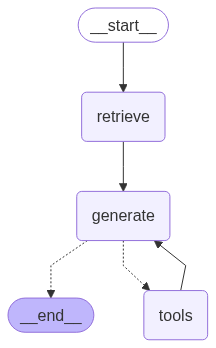

In [67]:
display(Image(graph.get_graph().draw_mermaid_png()))

<span style="color: aqua; font-size:150%">The RAG nodes have been augmented with a tools node that is conditionally triggered when the LLM infers that a prompt is related to one of its tools.</span>

In [68]:
config = {"configurable": {"thread_id": "1"}}
events = assistant.stream(
    { 
        "role": "user",
        "content": "what are the arguments to the langchain StateGraph constructor? Can you ask a human expert please?"},
    config,
)
for event in events:
    print(event)

In [76]:
snapshot = graph.get_state(config)
snapshot.next

()

In [77]:
'''human_response = "The arguments to StateGraph are a and b"
events = graph.stream(Command(resume={"content":human_response}), config)
for event in events:
    print(event)'''

human_response = "The arguments to StateGraph are a and b"

# Wrap in the state format expected by your nodes
state = {"messages": [{"role": "user", "content": human_response}]}

# Stream through the graph
events = graph.stream(state, config)
for event in events:
    print(event)

{'retrieve': {'context': [Document(id='e1eade19-8ff8-4ee2-81db-cd392c38784b', metadata={'source': 'libs\\langchain\\langchain\\chains\\constitutional_ai\\base.py', 'file_path': 'libs\\langchain\\langchain\\chains\\constitutional_ai\\base.py', 'file_name': 'base.py', 'file_type': '.py'}, page_content='graph = StateGraph(State)\n            graph.add_node("generate_response", generate_response)\n            graph.add_node("critique_and_revise", critique_and_revise)\n\n            graph.add_edge(START, "generate_response")\n            graph.add_edge("generate_response", "critique_and_revise")\n            graph.add_edge("critique_and_revise", END)\n            app = graph.compile()\n\n        .. code-block:: python\n\n            constitutional_principles=[\n                ConstitutionalPrinciple(\n                    critique_request="Tell if this answer is good.",\n                    revision_request="Give a better answer.",\n                )\n            ]\n\n            query = "W